In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/nassim/dev/conrl


In [3]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.utils import *

import itertools
import time
import numpy as np
import pandas as pd
import gym
import time
import sys
import copy
from collections import namedtuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3, linewidth=80)

## Q-Learning

In [4]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 1.0,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.1
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)



In [26]:
stats_q =   {
            "step":  np.zeros(num_episodes),
            "cumulative_reward":  np.zeros(num_episodes),
            "q_tables": np.zeros(shape = (num_episodes, ) + state_size + (env.action_space.n, )),
            "best_actions": []
            }

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)

q_agent.train(env, num_episodes, stats_q)

Episode 0/500, Reward -1000.0, Total steps 1000.0, Epsilon: 1.00, Alpha: 0.10, Time 0.124
Episode 100/500, Reward -1000.0, Total steps 1000.0, Epsilon: 0.64, Alpha: 0.10, Time 0.090
Episode 200/500, Reward -255.0, Total steps 255.0, Epsilon: 0.28, Alpha: 0.10, Time 0.040
Episode 300/500, Reward -571.0, Total steps 571.0, Epsilon: 0.10, Alpha: 0.10, Time 0.066
Episode 400/500, Reward -1000.0, Total steps 1000.0, Epsilon: 0.10, Alpha: 0.10, Time 0.114


## Con-RL

In [6]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step
env.spec.max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 1.0,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.1
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

mlgng_params = {
    "ndim": 2, 
    "e_w":0.5, 
    "e_n":0.1, 
    "l":10, 
    "a":0.5, 
    "b":0.05,
    "k":1000.0, 
    "max_nodes": 10, 
    "max_age": 10
}

In [7]:
stats_cr= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes),
        "selector":    np.zeros(num_episodes),
        "mlgng_nodes":      [],
        "best_actions":     [],
}

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
conrl.init_support(**q_params)
conrl.init_mlgng(**mlgng_params)

conrl.train(env, num_episodes, stats_cr)


Episode 0/500, Reward -1000.0, Total steps 1000.0, Epsilon: 1.00, Alpha: 0.10, Time 0.162
	 MLGNG nodes per action layer: 0 0 0
Episode 100/500, Reward -171.0, Total steps 171.0, Epsilon: 0.64, Alpha: 0.10, Time 0.302
	 MLGNG nodes per action layer: 2 2 3
Episode 200/500, Reward -1000.0, Total steps 1000.0, Epsilon: 0.28, Alpha: 0.10, Time 1.172
	 MLGNG nodes per action layer: 10 10 10
Episode 300/500, Reward -288.0, Total steps 288.0, Epsilon: 0.10, Alpha: 0.10, Time 0.543
	 MLGNG nodes per action layer: 10 10 10
Episode 400/500, Reward -165.0, Total steps 165.0, Epsilon: 0.10, Alpha: 0.10, Time 0.356
	 MLGNG nodes per action layer: 10 10 9


## Statistics

In [278]:
from src.plotting import *

act_dict = {
    0: "Push left",
    1: "No push",
    2: "Push right"
}

act_symbol = {
    0:  "o",
    1: "^",
    2: "s",
}
act_color = cm.Dark2(np.linspace(0.1, 1, 3, endpoint=False))


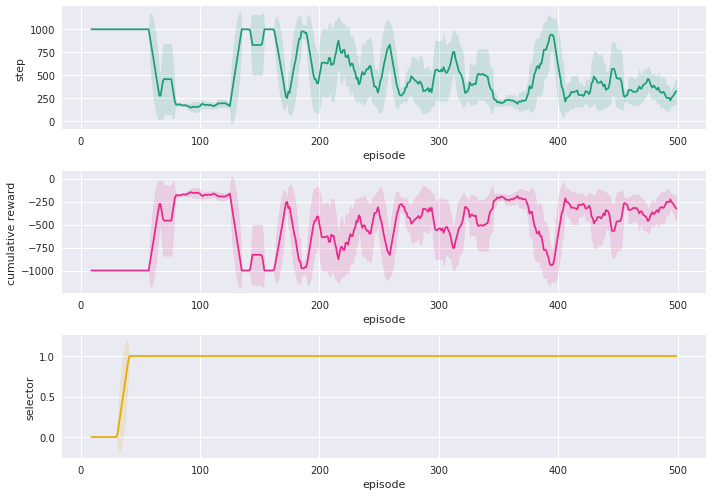

In [28]:
to_plot = ["step", "cumulative_reward", "selector"]

stats_to_plot = {key: value for key, value in stats_cr.items() if key in to_plot}
plot_stats(stats_to_plot, colors=act_color, figsize=(10, 7))

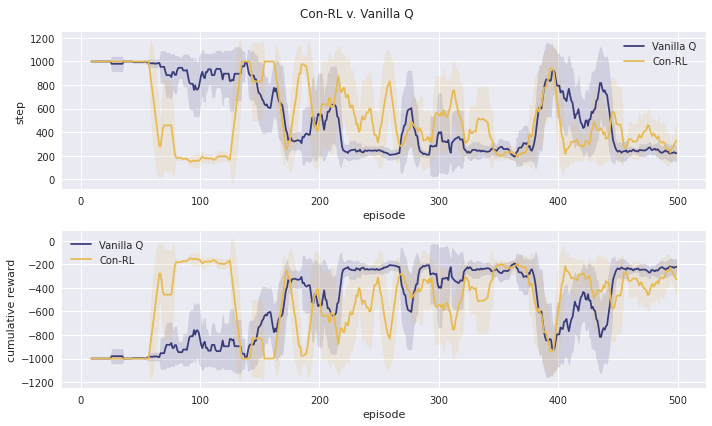

In [29]:
to_plot = ["step", "cumulative_reward"]
plot_stats_comparison({
    "Vanilla Q": {key: value for key, value in stats_q.items() if key in to_plot}, 
    "Con-RL": {key: value for key, value in stats_cr.items() if key in to_plot}
},
title="Con-RL v. Vanilla Q")

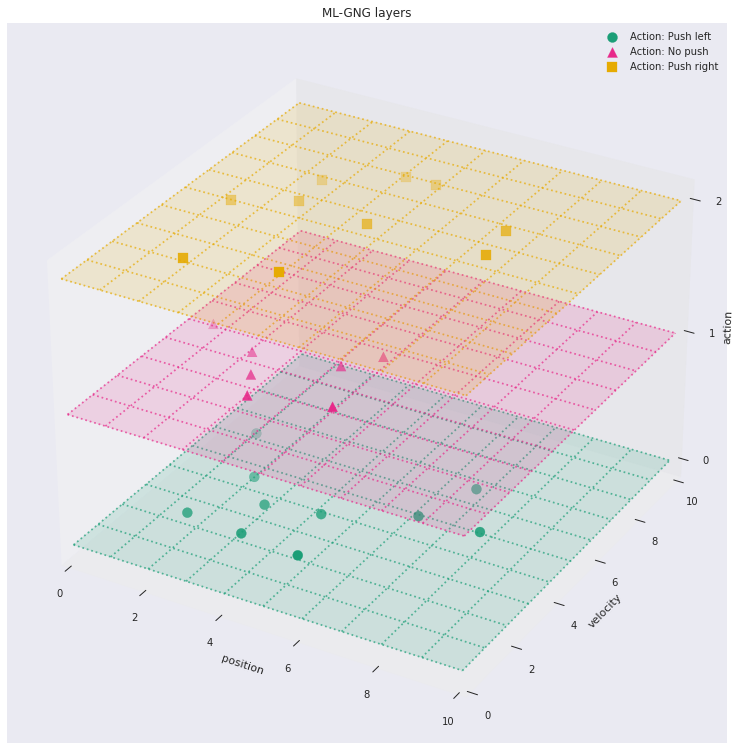

In [30]:
nodes = conrl.mlgng.get_nodes()

plot_nodes_3d(
            nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,   
            axis_names=["position", "velocity", "action"])

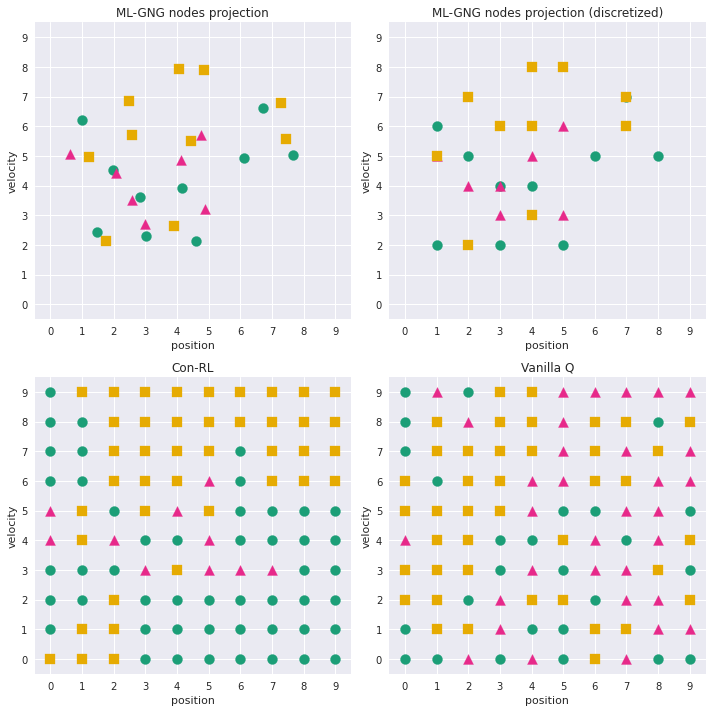

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax = ax.flatten()

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection (discretized)",
            round=True,
            def_plot=(fig, ax[1]),)

project_nodes(nodes=conrl.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL",
            def_plot=(fig, ax[2]))

project_nodes(nodes=q_agent.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q",
            def_plot=(fig, ax[3]))

fig.tight_layout()

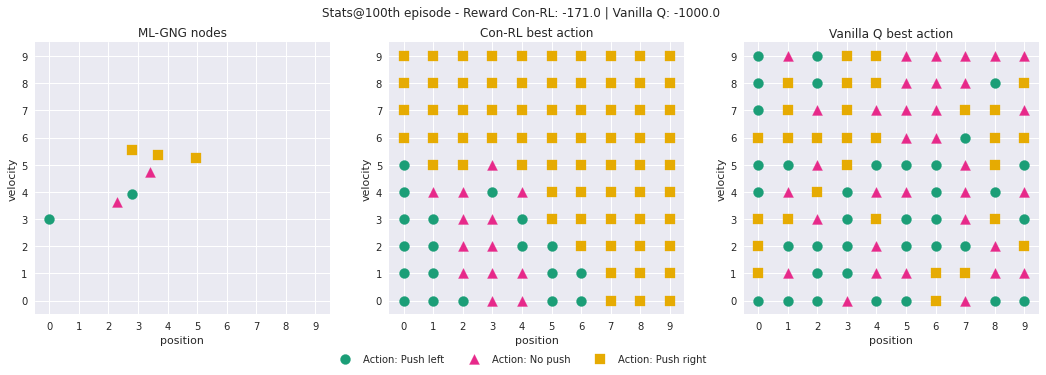

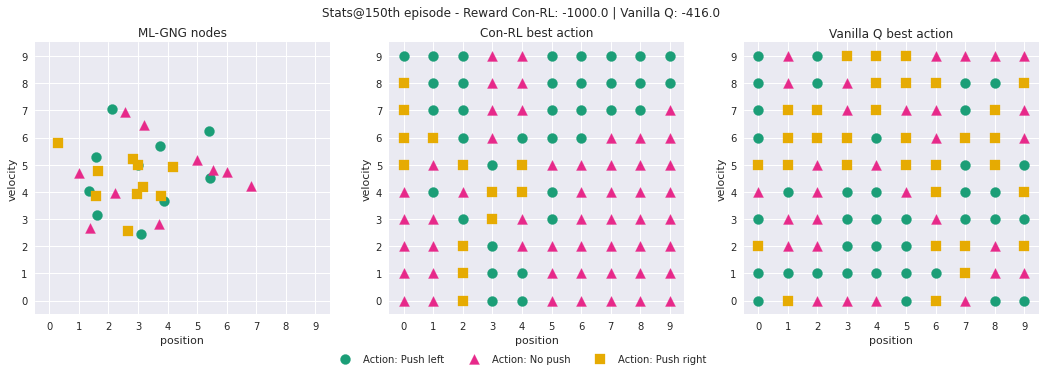

In [62]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
ax = ax.flatten()

ep = 100
fig.suptitle("Stats@{}th episode - Reward Con-RL: {} | Vanilla Q: {}".format(ep, stats_cr["cumulative_reward"][ep], stats_q["cumulative_reward"][ep]))
project_nodes(nodes=stats_cr["mlgng_nodes"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL best action",
            round=True,
            def_plot=(fig, ax[1]))

project_nodes(nodes=stats_q["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q best action",
            round=True,
            labels=True,
            def_plot=(fig, ax[2]),
            legend=False)
fig.legend(bbox_to_anchor=(0.5, 0.04), loc='upper center', ncol=3)

fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
ax = ax.flatten()

ep = 150
fig.suptitle("Stats@{}th episode - Reward Con-RL: {} | Vanilla Q: {}".format(ep, stats_cr["cumulative_reward"][ep], stats_q["cumulative_reward"][ep]))
project_nodes(nodes=stats_cr["mlgng_nodes"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL best action",
            round=True,
            def_plot=(fig, ax[1]))

project_nodes(nodes=stats_q["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q best action",
            round=True,
            labels=True,
            def_plot=(fig, ax[2]),
            legend=False)
fig.legend(bbox_to_anchor=(0.5, 0.04), loc='upper center', ncol=3)

In [248]:
act_symbol_plotly = {0:0, 1:5, 2:1}
act_color_plotly = act_color.copy()
act_color_plotly[:, 0:-1]=act_color_plotly[:, 0:-1]*255

In [282]:
plot_nodes_changes(stats_cr["mlgng_nodes"], 
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly)
plot_nodes_changes(stats_cr["best_actions"], 
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly)